# 直接使用工具包进行热力图生成

## 配置环境
需要的环境如下： \
torch \
pillow \
torchvision \
opencv-python == 4.3.0.38 \
jupyter notebook \
其他根据情况自己安装

In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from utils import GradCAM, show_cam_on_image, center_crop_img

In [2]:
# 使用mobilenet来实现
model = models.mobilenet_v3_large(pretrained=True)

# # 先打印一下模型结构
model

/home/qiu/anaconda3/envs/grad-cam/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/qiu/anaconda3/envs/grad-cam/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Grad-cam是作用在卷积层上，所以要选择一个卷积层（一般是最后一个卷积层），Grad-cam会在这个卷积层之后进行热力图计算。\
打印model.feature[-1],结果如下：
```
    (16): Conv2dNormActivation(
      (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(960, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
```
这是这个模型的最后一个卷积层，我们可以选择这个层。


In [3]:
target_layers = [model.features[-1]]

# 对输入图像做transform，步骤和正常的模型测试一模一样
data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# 读取测试图片
img_path = "dogcat.png"
img = Image.open(img_path).convert("RGB")
img = np.array(img, dtype=np.uint8)
input_tensor = data_transform(img)
input_tensor = torch.unsqueeze(input_tensor, dim=0)

In [4]:
# 定义Cam
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# 我们需要制定一个类别来显示热力图，281的类别为cat，254的类别为dog
target_category = 254

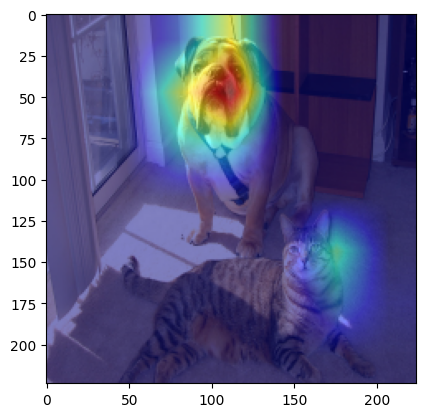

In [13]:
# 后边就是固定搭配，可视化
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                      grayscale_cam,
                                      use_rgb=True)
plt.imshow(visualization)
plt.show()